In [ ]:
import pandas as pd
df_B = pd.read_csv('Batting.csv')
df_P = pd.read_csv('Pitching.csv')



In [ ]:
Master_Dataset = pd.merge(df_B, df_P, on=['Team', 'Season'], how='inner')

In [ ]:
Master_Dataset.to_csv('Master_Dataset.csv', index=False)

## CP 5 Figs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

data_path = "Master_Dataset.csv"
fig_dir = Path("figures")
fig_dir.mkdir(exist_ok=True)

df = pd.read_csv(data_path)

df_eda = df[df["Season"] != 2020].copy()

df_eda["Total_WAR"] = df_eda["WAR_x"] + df_eda["WAR_y"]

plt.figure()
plt.hist(df_eda["W_x"], bins=15)
plt.title("Distribution of Team Wins (2010–2019, 2021–2025)")
plt.xlabel("Wins")
plt.ylabel("Number of Team-Seasons")
plt.tight_layout()
plt.savefig(fig_dir / "fig1_wins_hist.png")
plt.close()

plt.figure()
plt.hist(df_eda["Total_WAR"], bins=15)
plt.title("Distribution of Total WAR (Batting + Pitching)")
plt.xlabel("Total WAR")
plt.ylabel("Number of Team-Seasons")
plt.tight_layout()
plt.savefig(fig_dir / "fig2_totalwar_hist.png")
plt.close()

plt.figure()
plt.hist(df_eda["R/Gm"], bins=15)
plt.title("Distribution of Runs Scored per Game")
plt.xlabel("Runs per Game")
plt.ylabel("Number of Team-Seasons")
plt.tight_layout()
plt.savefig(fig_dir / "fig3_rpergame_hist.png")
plt.close()

plt.figure()
plt.hist(df_eda["ERA"], bins=15)
plt.title("Distribution of Team ERA")
plt.xlabel("ERA")
plt.ylabel("Number of Team-Seasons")
plt.tight_layout()
plt.savefig(fig_dir / "fig4_era_hist.png")
plt.close()

plt.figure()
plt.scatter(df_eda["Total_WAR"], df_eda["W_x"])
plt.title("Relationship Between Total WAR and Wins")
plt.xlabel("Total WAR")
plt.ylabel("Wins")
plt.tight_layout()
plt.savefig(fig_dir / "fig5_wins_vs_totalwar.png")
plt.close()

plt.figure()
plt.scatter(df_eda["R/Gm"], df_eda["W_x"])
plt.title("Relationship Between Runs per Game and Wins")
plt.xlabel("Runs per Game")
plt.ylabel("Wins")
plt.tight_layout()
plt.savefig(fig_dir / "fig6_wins_vs_rpergame.png")
plt.close()

plt.figure()
df_eda.boxplot(column="W_x", by="Lg_x")
plt.suptitle("")
plt.title("Wins by League (AL vs NL)")
plt.xlabel("League")
plt.ylabel("Wins")
plt.tight_layout()
plt.savefig(fig_dir / "fig7_wins_by_league.png")
plt.close()

season_sd = df_eda.groupby("Season")["W_x"].std()

plt.figure()
plt.plot(season_sd.index, season_sd.values, marker="o")
plt.title("Season-to-Season Parity: Std Dev of Wins by Season")
plt.xlabel("Season")
plt.ylabel("Standard Deviation of Wins")
plt.tight_layout()
plt.savefig(fig_dir / "fig8_sd_wins_by_season.png")
plt.close()


<Figure size 640x480 with 0 Axes>

## CP 7 Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

df = pd.read_csv("Master_Dataset.csv")

df = df.sort_values(["Team", "Season"])
df["W_next"] = df.groupby("Team")["W_x"].shift(-1)

mask_bad = (df["Season"].isin([2019, 2020])) | df["W_next"].isna()
df_model = df.loc[~mask_bad].copy()

df_model["rd_per_game"] = df_model["R/Gm"] - df_model["PtchR"]

df_model["runs_scored"] = df_model["R/Gm"] * df_model["GP_x"]
df_model["runs_allowed"] = df_model["PtchR"] * df_model["GP_x"]
df_model["pyth_pct"] = (
    df_model["runs_scored"] ** 2 /
    (df_model["runs_scored"] ** 2 + df_model["runs_allowed"] ** 2)
)
df_model["pyth_wins"] = df_model["pyth_pct"] * df_model["GP_x"]

feature_cols = [
    "WAR_x",
    "WAR_y",
    "R/Gm",
    "PtchR",
    "OPS_x",
    "OPS_y",
    "ERA",
    "FIP",
    "WHIP",
    "SO9",
    "BB9",
    "K%",
    "OPS+_x",
    "OPS+_y",
    "rd_per_game",
    "pyth_wins",
]

feature_cols = [c for c in feature_cols if c in df_model.columns]
X = df_model[feature_cols]
y = df_model["W_next"]

val_mask = df_model["Season"] == 2024
X_train = X.loc[~val_mask]
y_train = y.loc[~val_mask]
X_val = X.loc[val_mask]
y_val = y.loc[val_mask]

print("Train seasons:", df_model.loc[~val_mask, "Season"].unique())
print("Val seasons:", df_model.loc[val_mask, "Season"].unique())

gb_params = {
    "learning_rate": 0.05,
    "max_depth": 3,
    "max_iter": 500,
    "min_samples_leaf": 5,
    "l2_regularization": 0.0,
    "random_state": 42,
}
gb = HistGradientBoostingRegressor(**gb_params)
gb.fit(X_train, y_train)

y_val_pred = gb.predict(X_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
print("Gradient Boosting MAE on 2024→2025 holdout:", mae_val)

baseline_pred = df_model.loc[val_mask, "W_x"]
baseline_mae = mean_absolute_error(y_val, baseline_pred)
print("Baseline (current-season wins only) MAE:", baseline_mae)

from sklearn.inspection import permutation_importance
r = permutation_importance(
    gb, X_val, y_val, n_repeats=20, random_state=42
)
importances = pd.Series(r.importances_mean, index=X_val.columns)
print("Permutation importances on validation set:")
print(importances.sort_values(ascending=False))


Train seasons: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2021 2022 2023]
Val seasons: [2024]
Gradient Boosting MAE on 2024→2025 holdout: 7.066295452682105
Baseline (current-season wins only) MAE: 7.310344827586207
Permutation importances on validation set:
OPS+_y         0.299964
WAR_y          0.103535
WHIP           0.084153
OPS_x          0.048433
ERA            0.040650
BB9            0.024708
OPS+_x         0.020518
SO9            0.019597
R/Gm           0.009515
OPS_y         -0.003717
FIP           -0.005209
pyth_wins     -0.006048
PtchR         -0.009032
rd_per_game   -0.044111
WAR_x         -0.059270
K%            -0.118715
dtype: float64


In [ ]:

val_df = df_model.loc[val_mask].copy()

val_df["predicted_W_next"] = y_val_pred
val_df["actual_W_next"] = y_val

val_df["error"] = val_df["predicted_W_next"] - val_df["actual_W_next"]
val_df["abs_error"] = val_df["error"].abs()

results = val_df[["Season", "Team", "W_x", "actual_W_next", "predicted_W_next", "error", "abs_error"]]

results = results.sort_values("abs_error")

pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: f"{x:0.2f}")

print("\nPredicted vs Actual Wins for Next Season (2024 → 2025):\n")
print(results)



Predicted vs Actual Wins for Next Season (2024 → 2025):

    Season Team  W_x  actual_W_next  predicted_W_next  error  abs_error
42    2024  HOU   88          87.00             87.00   0.00       0.00
37    2024  CIN   77          83.00             82.92  -0.08       0.08
43    2024  KCR   86          82.00             82.17   0.17       0.17
55    2024  STL   83          78.00             78.22   0.22       0.22
54    2024  SFG   80          81.00             80.56  -0.44       0.44
52    2024  SDP   93          90.00             91.16   1.16       1.16
30    2024  LAA   63          72.00             70.72  -1.28       1.28
53    2024  SEA   85          90.00             88.63  -1.37       1.37
38    2024  CLE   92          88.00             89.92   1.92       1.92
57    2024  TEX   78          81.00             83.61   2.61       2.61
41    2024  MIA   62          79.00             75.48  -3.52       3.52
51    2024  PIT   76          71.00             74.65   3.65       3.65
58    

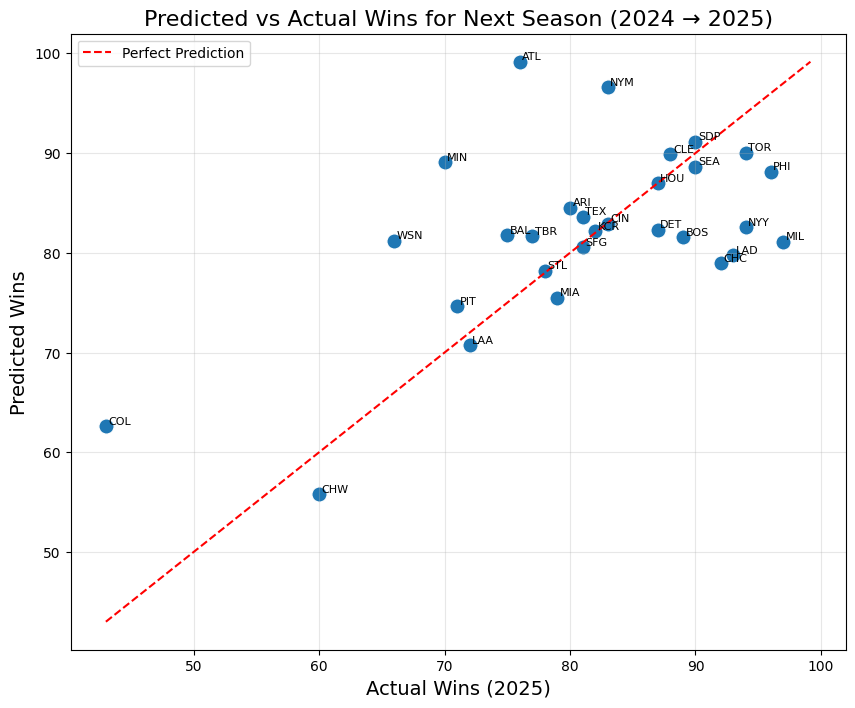

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = results.copy()

plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=plot_df,
    x="actual_W_next",
    y="predicted_W_next",
    s=120,
    color="tab:blue"
)

min_val = min(plot_df["actual_W_next"].min(), plot_df["predicted_W_next"].min())
max_val = max(plot_df["actual_W_next"].max(), plot_df["predicted_W_next"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Perfect Prediction")
=
plt.title("Predicted vs Actual Wins for Next Season (2024 → 2025)", fontsize=16)
plt.xlabel("Actual Wins (2025)", fontsize=14)
plt.ylabel("Predicted Wins", fontsize=14)

for _, row in plot_df.iterrows():
    plt.text(
        row["actual_W_next"] + 0.2,
        row["predicted_W_next"] + 0.2,
        row["Team"],
        fontsize=8
    )

plt.legend()
plt.grid(True, alpha=0.3)

plt.show()
